In [124]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [125]:
df = pd.read_csv('Starbucks Dataset.csv')

In [126]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1992-06-26,0.328125,0.347656,0.320313,0.335938,0.260703,224358400
1,1992-06-29,0.339844,0.367188,0.332031,0.359375,0.278891,58732800
2,1992-06-30,0.367188,0.371094,0.343750,0.347656,0.269797,34777600
3,1992-07-01,0.351563,0.359375,0.339844,0.355469,0.275860,18316800
4,1992-07-02,0.359375,0.359375,0.347656,0.355469,0.275860,13996800


## Exploring and vsualizing the Data

In [127]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8031,2024-05-17,75.269997,78.000000,74.919998,77.849998,77.849998,14436500
8032,2024-05-20,77.680000,78.320000,76.709999,77.540001,77.540001,11183800
8033,2024-05-21,77.559998,78.220001,77.500000,77.720001,77.720001,8916600
8034,2024-05-22,77.699997,81.019997,77.440002,80.720001,80.720001,22063400
8035,2024-05-23,80.099998,80.699997,79.169998,79.260002,79.260002,4651418


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8036 non-null   object 
 1   Open       8036 non-null   float64
 2   High       8036 non-null   float64
 3   Low        8036 non-null   float64
 4   Close      8036 non-null   float64
 5   Adj Close  8036 non-null   float64
 6   Volume     8036 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 439.6+ KB


In [129]:
df['Date'] = pd.to_datetime(df['Date'])

In [130]:
df.shape

(8036, 7)

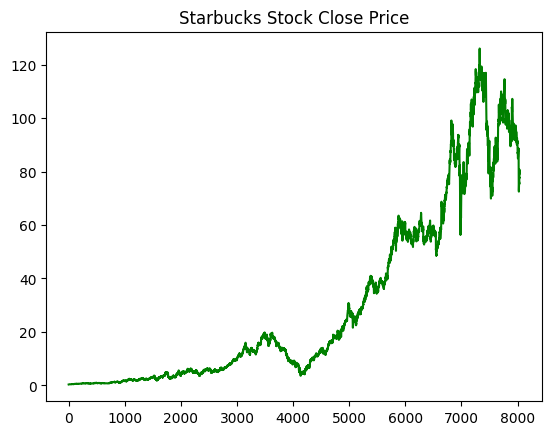

In [131]:
# plot the close price of the stock
df['Close'].plot(color='green', title='Starbucks Stock Close Price')
plt.show();

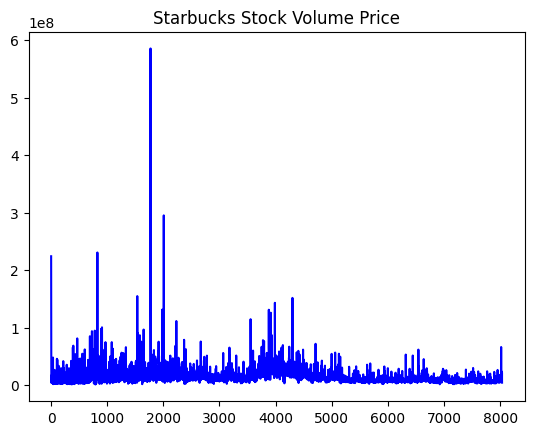

In [132]:
# plot the close price of the stock
df['Volume'].plot(color='blue', title='Starbucks Stock Volume Price')
plt.show();

In [133]:
X = df['Close'].to_numpy()
X

array([ 0.335938,  0.359375,  0.347656, ..., 77.720001, 80.720001,
       79.260002])

In [134]:
X.shape

(8036,)

## MinMax Scaling the Data

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1))

In [136]:
X_scaled

array([[0.00000000e+00],
       [1.86416188e-04],
       [9.32041170e-05],
       ...,
       [6.15507191e-01],
       [6.39368972e-01],
       [6.27756246e-01]])

In [137]:
X_scaled.shape

(8036, 1)

## Splitting into Training and testing

In [138]:
def make_train_test_split(train_size:float, data):
    train_index = int(len(data) * train_size)
    train = data[:train_index]
    test = data[train_index:]
    return train, test

In [139]:
train_data, test_data = make_train_test_split(data=X_scaled, train_size=0.8)

In [140]:
train_data.shape, test_data.shape

((6428, 1), (1608, 1))

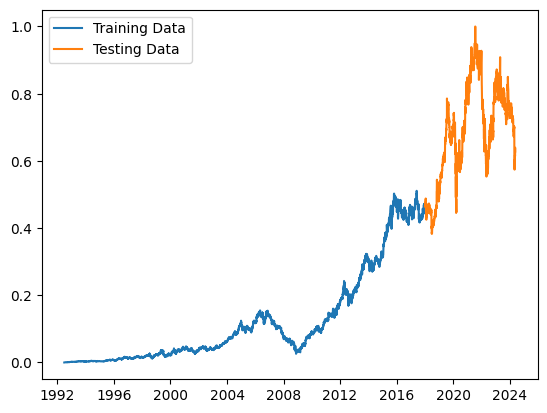

In [141]:
plt.plot(df['Date'][:6428], train_data, label='Training Data')
plt.plot(df['Date'][6428:], test_data, label='Testing Data')
plt.legend()

## Windowing our dataset

In [142]:
def make_windowed_datasets(data, window_size, horizon_size):
    X = []
    y = []
    for i in range(len(data)-(window_size + horizon_size)):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

In [143]:
X_train, y_train = make_windowed_datasets(train_data, window_size=7, horizon_size=1)
X_test, y_test = make_windowed_datasets(test_data, window_size=7, horizon_size=1)

In [144]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6420, 7), (6420,), (1600, 7), (1600,))

In [145]:
X_train[0]

array([0.00000000e+00, 1.86416188e-04, 9.32041170e-05, 1.55348149e-04,
       1.55348149e-04, 1.55348149e-04, 1.55348149e-04])

In [146]:
print(f'Input Day 1 : \n {scaler.inverse_transform(X_train[0].reshape(-1, 1))}')
print(f'Output Day 1: \n {scaler.inverse_transform(y_train[0].reshape(-1, 1))}')

Input Day 1 : 
 [[0.335938]
 [0.359375]
 [0.347656]
 [0.355469]
 [0.355469]
 [0.355469]
 [0.355469]]
Output Day 1: 
 [[0.347656]]


In [147]:
# reshaping our X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [148]:
X_train.shape, X_test.shape

((6420, 1, 7), (1600, 1, 7))

## Modelling Experiments
* Simple LSTM model
* Complex LSTM model
* CNN model

In [149]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name + '.keras'), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [150]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [151]:
model1 = Sequential()
model1.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(1, 7)))
model1.add(LSTM(64, activation='relu'))

model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='linear'))

# compiling our model
model1.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mse']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [152]:
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 64)          │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,729 (225.50 KB)

 Trainable params: 57,729 (225.50 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
history1 = model1.fit(X_train, y_train,
                     epochs=70,
                     validation_data=(X_test, y_test),
                     callbacks=[create_model_checkpoint(model_name='Simple_LSTM_model')])

Epoch 1/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2780e-05 - mse: 2.2780e-05 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 3/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1278e-05 - mse: 2.1278e-05 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 4/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4647e-05 - mse: 2.4647e-05 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.1022e-05 - mse: 2.1022e-05 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 6/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.1497e-05 - mse: 2.1497e-05 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.3387e-05 - mse: 2.3387e-05 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/70
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6736e-05 - mse: 2.6736e-05 - val_loss: 0.0018 - val_mse: 0.0018

## Evaluating a model

In [154]:
model1.evaluate(X_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3300e-04 - mse: 5.3300e-04


[0.0009421823779121041, 0.0009421823779121041]

In [155]:
# lets get the best performing stored model in the modelling experiments folder
model1 = tf.keras.models.load_model('model_experiments/Simple_LSTM_model.keras')
model1.evaluate(X_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9333e-04 - mse: 1.9333e-04


[0.0002685914223548025, 0.0002685914223548025]

In [156]:
model1.evaluate(X_train, y_train)

201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6009e-06 - mse: 3.6009e-06


[1.1927136256417725e-05, 1.1927136256417725e-05]

In [157]:
y_preds = tf.squeeze(model1.predict(X_test))
y_preds[:5]

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.4674493 , 0.46997038, 0.47215584, 0.4736685 , 0.47589335],
      dtype=float32)>

In [158]:
from sklearn.metrics import r2_score
import tensorflow as tf # Import tensorflow to use its metrics

# Make sure float32 (for metric calculations)
y_test = tf.cast(y_test, dtype=tf.float32)
y_preds = tf.cast(y_preds, dtype=tf.float32)

# Calculate various metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(y_test, y_preds)
mae = mae_metric.result()

mse_metric = tf.keras.metrics.MeanSquaredError()
mse_metric.update_state(y_test, y_preds)
mse = mse_metric.result() # puts and emphasis on outliers (all errors get squared)

rmse = tf.sqrt(mse)

mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
mape_metric.update_state(y_test, y_preds)
mape = mape_metric.result()

r2 = r2_score(y_test.numpy(), y_preds.numpy())

print(f"""
MAE : {mae.numpy()}
MSE : {mse.numpy()}
RMSE : {rmse.numpy()}
MAPE : {mape.numpy()}
R2 Score : {r2}""")


MAE : 0.011942765675485134
MSE : 0.0002685914223548025
RMSE : 0.01638875901699066
MAPE : 1.7306222915649414
R2 Score : 0.9870320558547974


<Axes: >

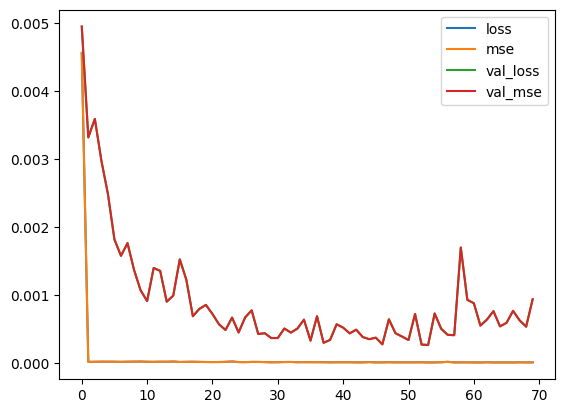

In [159]:
pd.DataFrame(history1.history).plot()

## Visualzing our predictions on Test Data

Text(0.5, 1.0, 'Test Data vs. Predictions')

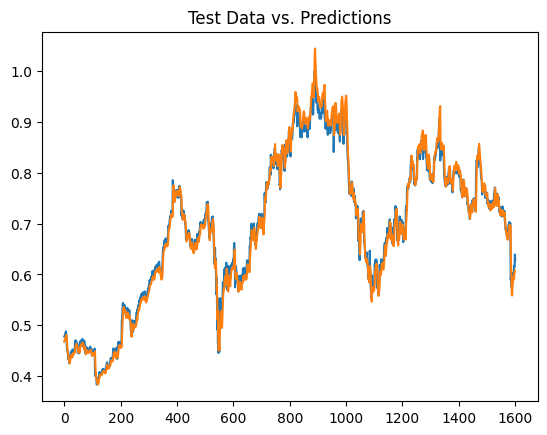

In [160]:
plt.plot(test_data[7:len(X)-(7+1)])
plt.plot(y_preds)
plt.title('Test Data vs. Predictions')

## Future Predictions of best model

In [161]:
import datetime

def future_prediction(data, days=30):
    model_inputs = data[-1]
    predictions = []

    for i in range(days):
        y_pred = model1.predict(tf.expand_dims(model_inputs, axis=0))
        model_inputs[:, :-1] = model_inputs[:, 1:]
        model_inputs[:, -1] = y_pred
        y_pred = tf.squeeze(scaler.inverse_transform(y_pred))
        predictions.append(y_pred)

    predictions = np.array(predictions)
    return predictions

In [162]:
predictions = future_prediction(X_test, 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

In [163]:
# making a date array (required when plotting)
today = np.datetime64(datetime.date.today())
date_array = today + np.arange(30)

In [168]:
predictions

array([76.73113 , 76.32407 , 75.90794 , 75.19143 , 74.51897 , 73.832924,
       73.18633 , 72.511314, 71.82577 , 71.15972 , 70.50143 , 69.85053 ,
       69.20709 , 68.57595 , 67.95811 , 67.351204, 66.750786, 66.15712 ,
       65.568344, 64.986465, 64.41173 , 63.844513, 63.28559 , 62.735653,
       62.195404, 61.665375, 61.1461  , 60.638096, 60.141773, 59.657482],
      dtype=float32)

## Saving the model

In [167]:
model1.save('Starbucks_lstm_model.h5')

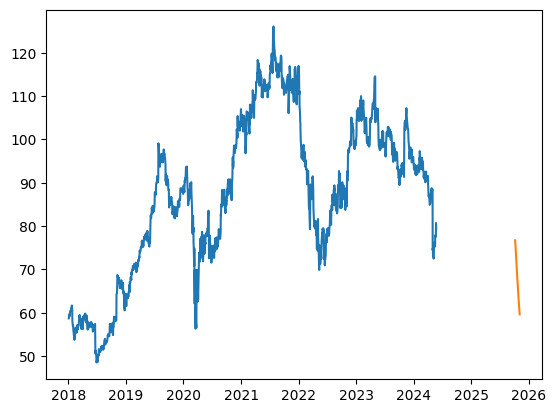

In [165]:
plt.plot(df['Date'][int(len(X_scaled)*0.8):], tf.squeeze(scaler.inverse_transform(test_data)))
plt.plot(date_array, predictions)